In [1]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.0 MB/s eta 0:00:00


In [44]:
import tensorflow as tf
import os
import shutil
import pickle
from google.colab import files 
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D  
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
import tensorflow_addons as tfa
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers.core import Activation
from keras.callbacks import ReduceLROnPlateau
from datetime import datetime
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from PIL import Image
import cv2
from tensorflow.keras.applications import ResNet50
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback

from skimage import io
from skimage.transform import resize

## Init Program

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Unzip Data

In [4]:
! unzip '/content/drive/Shareddrives/Teman Tani/Capstone 2023/Machine Learning/Datasets/Potato/train-data.zip' -d . 

Archive:  /content/drive/Shareddrives/Teman Tani/Capstone 2023/Machine Learning/Datasets/Potato/train-data.zip
   creating: ./Train/Early Blight/
  inflating: ./Train/Early Blight/009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG  
  inflating: ./Train/Early Blight/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG  
  inflating: ./Train/Early Blight/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015_180deg.JPG  
  inflating: ./Train/Early Blight/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015_flipTB.JPG  
  inflating: ./Train/Early Blight/0267d4ca-522e-4ca0-b1a2-ce925e5b54a2___RS_Early.B 7020.JPG  
  inflating: ./Train/Early Blight/0267d4ca-522e-4ca0-b1a2-ce925e5b54a2___RS_Early.B 7020_180deg.JPG  
  inflating: ./Train/Early Blight/0267d4ca-522e-4ca0-b1a2-ce925e5b54a2___RS_Early.B 7020_flipTB.JPG  
  inflating: ./Train/Early Blight/028f9b73-142f-499a-9c7b-d7c1ed5e5506___RS_Early.B 8546.JPG  
  inflating: ./Train/Early Blight/034959c1-f1e8-4a79-a6d5-3c1d14ef

In [ ]:
os.listdir('/content/drive/Shareddrives/Teman Tani/Capstone 2023')

['Teman Tani Bangkit 2023 Product-based Capstone.gdoc',
 'Machine Learning',
 'Teman Tani Schedule.gsheet',
 'Mobile']

### Supporting Function

In [45]:
from tensorflow.keras.callbacks import Callback

class StopTrainingCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= 0.95:
            print("Validation accuracy reached 0.95 or higher. Stopping training.")
            self.model.stop_training = True

In [46]:
def callbacks(filename):
  es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)
  reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                          factor = 0.3,
                          patience = 3,
                          min_lr = 1e-6,
                          mode = 'min',
                          verbose = 1)
  mc = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  stop_training_callback = StopTrainingCallback()

  return [es, mc, reduce_lr, stop_training_callback]

In [47]:
def predict_new_data(model, shape, path):
  labels = (train_generator.class_indices)
  labels = dict((v,k) for k,v in labels.items())

  img = load_img(path, target_size=shape)
  imgplot = plt.imshow(img)
  target = img_to_array(img)
  target = np.expand_dims(target, axis=0)
  target = np.vstack([target])
  target /= 255
  pred = model.predict(target)
  return labels[np.argmax(pred, axis=1)[0]]

In [48]:
def save_model(name, model, model_dir):
  path = os.path.join(model_dir, name)
  if os.path.isdir(path):
    print('\nReplacing the model with the new One\n')
    shutil.rmtree(path, ignore_errors=True)

  model.save(path)
  print("Export path: ", path)
  print(os.listdir(path))

### Prepare Data

In [49]:
image_shape=255
datagen = ImageDataGenerator(
       rotation_range=40, 
            width_shift_range=0.15, 
            height_shift_range=0.15, 
            zoom_range=0.1, 
            rescale=1.0/255,
            horizontal_flip=True, 
            vertical_flip=True, 
            brightness_range=[0.75,1.25],
            validation_split=0.2
)

val_datagen=ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)
batch_size = 70 #Bisa diganti2

train_generator = datagen.flow_from_directory(
    '/content/Train',
    target_size =(255,255),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset='training',
    
)

validation_generator = val_datagen.flow_from_directory(
    '/content/Train',
    target_size = (255,255),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset='validation',
    shuffle=False
)

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [50]:
train_generator.class_indices

{'Early Blight': 0, 'Healthy': 1, 'Late Blight': 2}

## Modelling

In [38]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

### Model 1 (DenseNet121) 0.98 VAL ACC

In [ ]:

from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense


In [ ]:
model1 = Sequential()
model1.add(tf.keras.applications.DenseNet121(input_shape = (255, 255, 3), include_top = False, weights = 'imagenet' ))
model1.add(Dropout(0.4))
model1.add(GlobalAveragePooling2D())
model1.add(Dense(512, activation = 'relu',bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
model1.add(Dropout(0.4))
model1.add(Dense(3, activation = 'softmax'))

29084464/29084464 [==============================] - 3s 0us/step


In [ ]:
model1.compile(loss= tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.001,
                                                   name='categorical_crossentropy' ),
              optimizer=Adam(learning_rate = 2e-4),
              metrics=['accuracy'])

In [ ]:
 history = model1.fit(train_generator,
                             validation_data = validation_generator,
                             epochs= 30,
                             batch_size = 32,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                            callbacks=callbacks("Model_DenseNet121.h5")
                            )

Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 0.1701 - accuracy: 0.9318
Epoch 1: val_accuracy improved from -inf to 0.88750, saving model to Model_DenseNet121.h5
34/34 [==============================] - 152s 2s/step - loss: 0.1701 - accuracy: 0.9318 - val_loss: 0.5407 - val_accuracy: 0.8875 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 0.0289 - accuracy: 0.9923
Epoch 2: val_accuracy improved from 0.88750 to 0.94286, saving model to Model_DenseNet121.h5
34/34 [==============================] - 62s 2s/step - loss: 0.0289 - accuracy: 0.9923 - val_loss: 0.2263 - val_accuracy: 0.9429 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9974
Epoch 3: val_accuracy did not improve from 0.94286
34/34 [==============================] - 61s 2s/step - loss: 0.0174 - accuracy: 0.9974 - val_loss: 0.2801 - val_accuracy: 0.9214 - lr: 2.0000e-04
Epoch 4/30
34/34 [===========================

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
label_types = []
for category in train_generator.class_indices:
  label_types.append(category)
label_types

['Early Blight', 'Healthy', 'Late Blight']

In [ ]:
y_test = validation_generator.classes
y_pred = model1.predict_generator(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

<ipython-input-17-1f97d7f25348>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model1.predict_generator(validation_generator)


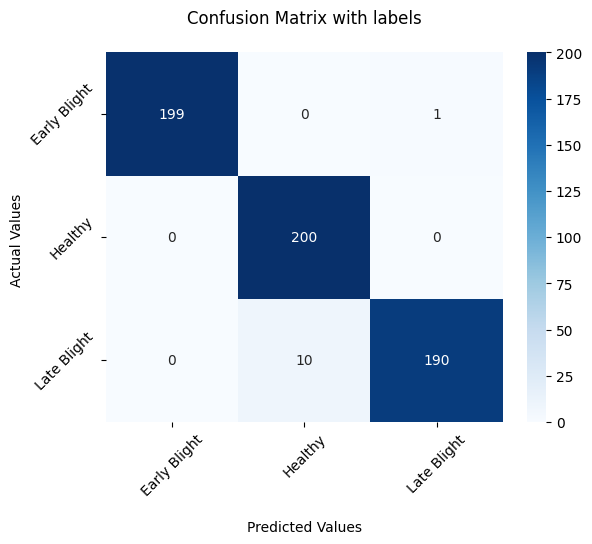

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')
ax.set_title('Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(label_types, rotation=45)
ax.yaxis.set_ticklabels(label_types, rotation=45)

plt.show()

In [ ]:
def normalize_image(image):
    height, width, _ = image.shape
    norm_size = max(height, width)
    add_h = norm_size - height
    add_w = norm_size - width
    start_add_h = add_h // 2
    start_add_w = add_w // 2
    new_img = np.full((norm_size, norm_size, 3), 255, dtype=np.uint8)
    new_img[start_add_h:start_add_h + height, start_add_w:start_add_w + width, :] = image
    return new_img

def preprocessing(image):
  img = normalize_image(image)
  img = cv2.resize(img, (300, 300), interpolation = cv2.INTER_AREA)
  return np.array(img)
     

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/Shareddrives/Teman Tani/Capstone 2023/Machine Learning/Code/Potato/Model/Densenet121-0.98val')

1/1 [==============================] - 10s 10s/step


'Early Blight'

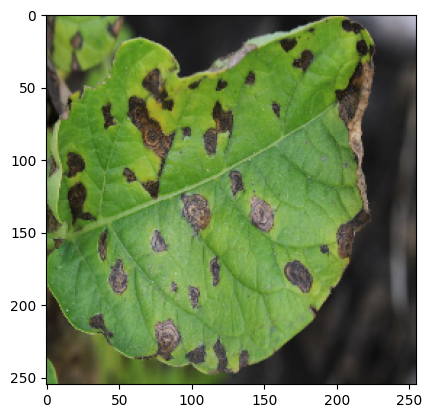

In [ ]:
predict_new_data(new_model, (255,255), '/content/potato-early-blight-lesions.jpeg')

In [ ]:
save_model("Densenet121-0.98val", model1, "/content/drive/Shareddrives/Teman Tani/Capstone 2023/Machine Learning/Code/Potato/Model")

Export path:  /content/drive/Shareddrives/Teman Tani/Capstone 2023/Machine Learning/Code/Potato/Model/Densenet121-0.98val
['variables', 'assets', 'fingerprint.pb', 'saved_model.pb', 'keras_metadata.pb']


In [ ]:
new_model = tf.keras.models.load_model('/content/Model_DenseNet121.h5')

### Model 2 (MobileNetV2 0.96 Acc)

In [11]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 

In [13]:
model2 = tf.keras.models.Sequential([
    MobileNetV2(weights="imagenet", include_top=False, input_shape=(255,255,3)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  
])

model2.layers[0].trainable = False

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 3)                

In [14]:
model2.compile(loss= tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.001,
                                                   name='categorical_crossentropy' ),
              optimizer=Adam(learning_rate = 2e-4),
              metrics=['accuracy'])

In [15]:
 history2 = model2.fit(train_generator,
                             validation_data = validation_generator,
                             epochs= 30,
                             batch_size = 64,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                            callbacks=callbacks("Model_MobileNetV2.h5")
                            )

Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 0.4668 - accuracy: 0.8227
Epoch 1: val_accuracy improved from -inf to 0.96607, saving model to Model_MobileNetV2.h5
Validation accuracy reached 0.95 or higher. Stopping training.
34/34 [==============================] - 59s 1s/step - loss: 0.4668 - accuracy: 0.8227 - val_loss: 0.1495 - val_accuracy: 0.9661 - lr: 2.0000e-04


In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [17]:
label_types = list(train_generator.class_indices.keys())
label_types

['Early Blight', 'Healthy', 'Late Blight']

In [18]:
y_test = validation_generator.classes
y_pred = model2.predict_generator(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

<ipython-input-18-b6fc1ad3b738>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model2.predict_generator(validation_generator)


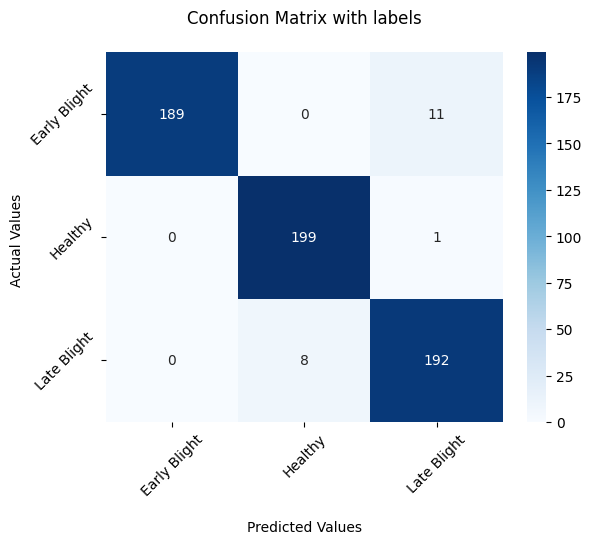

In [19]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')
ax.set_title('Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(label_types, rotation=45)
ax.yaxis.set_ticklabels(label_types, rotation=45)

plt.show()

1/1 [==============================] - 0s 159ms/step


'Late Blight'

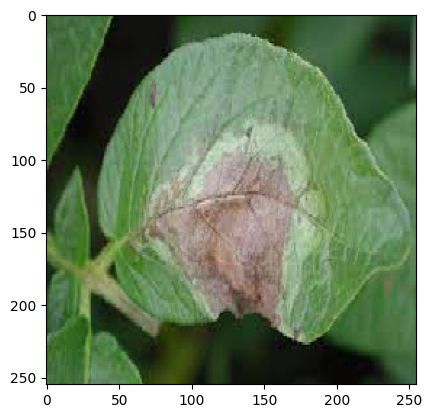

In [25]:
predict_new_data(model2, (255,255), '/content/lateblight.jpeg')

In [20]:
save_model("MobileNetV2-0.96val", model2, "/content/drive/Shareddrives/Teman Tani/Capstone 2023/Machine Learning/Code/Potato/Model")

Export path:  /content/drive/Shareddrives/Teman Tani/Capstone 2023/Machine Learning/Code/Potato/Model/MobileNetV2-0.96val
['variables', 'assets', 'fingerprint.pb', 'saved_model.pb', 'keras_metadata.pb']


In [ ]:
new_model = tf.keras.models.load_model('/content/drive/Shareddrives/Teman Tani/Capstone 2023/Machine Learning/Code/Cassava/Model/Densenet121-0.81val')

### Model 3 

In [51]:
from tensorflow.keras.applications.efficientnet import EfficientNetB1

In [60]:
model3 = tf.keras.models.Sequential([
    EfficientNetB1(weights="imagenet", include_top=False, input_shape=(image_shape,image_shape,3)),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(3, activation='softmax')  
])

model3.layers[0].trainable = False

model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 8, 8, 1280)       6575239   
                                                                 
 dropout_14 (Dropout)        (None, 8, 8, 1280)        0         
                                                                 
 global_average_pooling2d_6   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_19 (Dense)            (None, 512)               655872    
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 256)               131328    
                                                      

In [57]:
class CustomModelCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_loss', mode='auto', save_best_only=False):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        self.best_value = None

    def on_epoch_end(self, epoch, logs=None):
        current_value = logs.get(self.monitor)
        if self.best_value is None or self._is_improvement(current_value):
            self.best_value = current_value
            self.model.save_weights(self.filepath, overwrite=True)
            print(f"Saved weights at epoch {epoch+1} with {self.monitor}: {current_value}")

    def _is_improvement(self, current):
        if self.mode == 'auto':
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                return current > self.best_value
            else:
                return current < self.best_value
        elif self.mode == 'min':
            return current < self.best_value
        else:
            return current > self.best_value

def callbacks(filename):
    es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, mode='min', verbose=1)
    mc = CustomModelCheckpoint(filename, monitor='val_accuracy', mode='max', save_best_only=True)

    return [es, mc, reduce_lr]

In [61]:
model3.compile(loss= tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.001,
                                                   name='categorical_crossentropy' ),
              optimizer=Adam(learning_rate = 1e-6),
              metrics=['accuracy'])

In [ ]:
 history3 = model3.fit(train_generator,
                             validation_data = validation_generator,
                             epochs= 30,
                             batch_size = 64,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                            callbacks=callbacks("Model_EfficientNetB7.h5")
                            )

Epoch 1/30
34/34 [==============================] - 63s 2s/step - loss: 270.2981 - accuracy: 0.3382 - val_loss: 269.7840 - val_accuracy: 0.2857 - lr: 1.0000e-06
Epoch 2/30
34/34 [==============================] - 49s 1s/step - loss: 270.0714 - accuracy: 0.3361 - val_loss: 269.5324 - val_accuracy: 0.2857 - lr: 1.0000e-06
Epoch 3/30
34/34 [==============================] - 49s 1s/step - loss: 269.8502 - accuracy: 0.3348 - val_loss: 269.2809 - val_accuracy: 0.2857 - lr: 1.0000e-06
Epoch 4/30
34/34 [==============================] - 49s 1s/step - loss: 269.5673 - accuracy: 0.3180 - val_loss: 269.0297 - val_accuracy: 0.2857 - lr: 1.0000e-06
Epoch 5/30
34/34 [==============================] - 49s 1s/step - loss: 269.2665 - accuracy: 0.3558 - val_loss: 268.7787 - val_accuracy: 0.2857 - lr: 1.0000e-06
Epoch 6/30
34/34 [==============================] - 49s 1s/step - loss: 269.0222 - accuracy: 0.3399 - val_loss: 268.5281 - val_accuracy: 0.2857 - lr: 1.0000e-06
Epoch 7/30
34/34 [================